In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import operator
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy.stats as stats
from  scipy.stats import chi2_contingency,chisquare
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import multipletests

from util.api import calculate_bottom_dict
from util.api import create_lts_obj, compute_monad_usage_by_df, calculate_bottom, get_lts_list

%matplotlib inline
plt.style.use('classic')

In [2]:
lts_list = get_lts_list()
df_list = []
df_by_category_list = []

for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/lts-{lts}/lts-{lts}.df')
    df_list.append(df)
    
for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/lts-{lts}/lts-{lts}-by-category.df')
    df_by_category_list.append(df)

# El valor p es para determinar si puede o no puede rechazar la hipótesis nula, que dice que no existe ninguna asociación entre dos variables categóricas.

Valor p ≤ α: Las variables tienen una asociación estadísticamente significativa (Rechazar H0)
Si el valor p es menor que o igual al nivel de significancia, usted rechaza la hipótesis nula y concluye que hay una asociación estadísticamente significativa entre las variables.

Valor p > α: No se puede concluir que las variables están asociadas (No se puede rechazar H0)
Si el valor p es mayor que el nivel de significancia, usted no puede rechazar la hipótesis nula, porque no hay suficiente evidencia para concluir que las variables están asociadas.

## Cada valor categorico es comparado con el total de paquetes presentes en cada una de las versiones LTS

## Calcular el valor de PValue para las categorias de Stackage

In [3]:
categories = ['data', 'web', 'control', 'text', 'network']
data = {
    'data': [],
    'web': [],
    'control': [],
    'text': [],
    'network': []
}
count_pkgs = {
    'data': [],
    'web': [],
    'control': [],
    'text': [],
    'network': []
}
df_by_cat = []


for idx, df in enumerate(df_by_category_list):
    aux_df = df[['package', 'category']]
    aux_df = aux_df.groupby(['category']).count().reset_index().rename(columns={"package": "count"})
    aux_df.loc[:, 'version'] = lts_list[idx]
    df_by_cat.append(aux_df.sort_values(by=['count'], ascending=False))
    
for category in categories:
    for idx, lts in enumerate(lts_list):
        total_pkgs = len(df_by_category_list[idx])
        aux = int(df_by_cat[idx][df_by_cat[idx]['category'] == category]['count']) * 100 / total_pkgs   

        count = int(df_by_cat[idx][df_by_cat[idx]['category'] == category]['count'])
        count_pkgs[category].append(count)
        data[category].append(aux)

others = []
per_others = []
for idx, lts in enumerate(lts_list):
    count = 0
    for category in count_pkgs:
        count += count_pkgs[category][idx]
    
    others.append(len(df_by_category_list[idx]) - count)
    per_others.append((len(df_by_category_list[idx]) - count) * 100 / len(df_by_category_list[idx]))

data['others'] = per_others
count_pkgs['others'] = others

# Test de anova

In [4]:
data = count_pkgs['data']
web = count_pkgs['web']
control = count_pkgs['control']
text = count_pkgs['text']
network = count_pkgs['network']


In [5]:
count_pkg = data + web + control + text + network
cat_list = [cat for idx,cat in enumerate(categories) for jdx,lts in enumerate(lts_list)]
dict_pkg = {'categories': cat_list, 'count_pkgs': count_pkg}

df_categories = pd.DataFrame(dict_pkg)

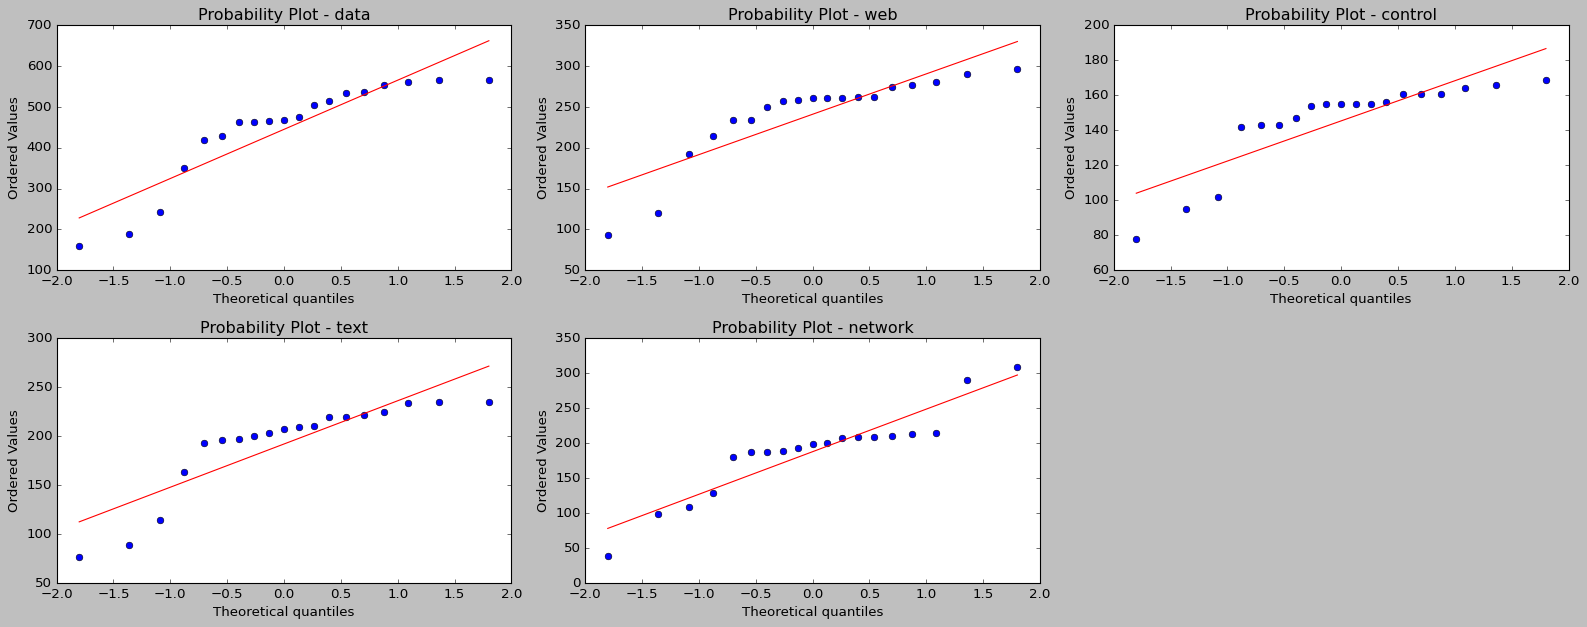

In [6]:
fig = plt.figure(figsize=(20,8))
unique_categories = df_categories['categories'].unique()

for idx,cat in enumerate(unique_categories):
    plt.subplot(2,3,idx+1)
    stats.probplot(df_categories[df_categories['categories'] == cat]['count_pkgs'], dist="norm", plot=plt)
    fig.tight_layout()
    plt.title("Probability Plot - " +  cat)
plt.show()

In [7]:
mod = ols('count_pkgs ~ categories',data=df_categories).fit()
aov_table= sm.stats.anova_lm(mod,typ=1)
print(aov_table)

              df        sum_sq        mean_sq          F        PR(>F)
categories   4.0  1.065676e+06  266419.089474  52.807427  8.000757e-23
Residual    90.0  4.540596e+05    5045.106433        NaN           NaN


In [8]:
f_val,p_val = stats.f_oneway(data,web,control,text,network)
print(p_val)

8.000756950244312e-23


group1,group2,meandiff,p-adj,lower,upper,reject
control,data,299.8421,0.001,235.6882,363.996,True
control,network,42.3158,0.3601,-21.8381,106.4697,False
control,text,46.5789,0.2644,-17.5749,110.7328,False
control,web,95.6842,0.001,31.5303,159.8381,True
data,network,-257.5263,0.001,-321.6802,-193.3724,True
data,text,-253.2632,0.001,-317.417,-189.1093,True
data,web,-204.1579,0.001,-268.3118,-140.004,True
network,text,4.2632,0.9,-59.8907,68.417,False
network,web,53.3684,0.1494,-10.7854,117.5223,False
text,web,49.1053,0.2163,-15.0486,113.2591,False


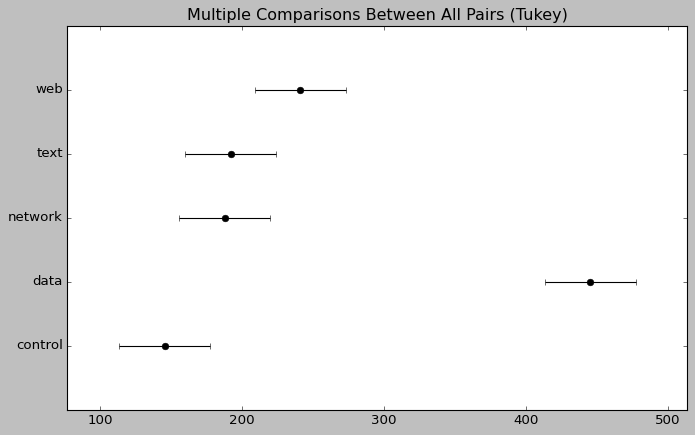

In [9]:
tukey = pairwise_tukeyhsd(endog=df_categories['count_pkgs'],
                         groups=df_categories['categories'],
                         alpha=0.05)
tukey.plot_simultaneous()

tukey.summary()

In [10]:
pvalue_list = []

for category in count_pkgs.keys():
    list_test_chi = []
    list_lts_len_cat = [len(df)-count_pkgs[category][idx] for idx,df in enumerate(df_by_category_list)]
    
    list_test_chi.append(count_pkgs[category])
    list_test_chi.append(list_lts_len_cat)
    
    chisq_statistic,pvalue,dof,expected_frep = chi2_contingency(list_test_chi)
    pvalue_list.append(pvalue)
    
    print(category,' have a pvalue of: ',pvalue)

data  have a pvalue of:  3.264464462603558e-05
web  have a pvalue of:  2.6942035052406142e-11
control  have a pvalue of:  0.001372803619987419
text  have a pvalue of:  0.9566948548405038
network  have a pvalue of:  2.9354679157042637e-26
others  have a pvalue of:  0.0010818425307787573


## Pvalue categorias con mónadas

In [11]:
categories = ['data', 'web', 'control', 'text', 'network']
data = {
    'data': [],
    'web': [],
    'control': [],
    'text': [],
    'network': []
}
count_pkgs_mon = {
    'data': [],
    'web': [],
    'control': [],
    'text': [],
    'network': []
}
df_by_cat = []
for idx, df in enumerate(df_by_category_list):
    aux_df = df[['package', 'category', 'mtl-direct']]
    aux_df = aux_df[aux_df['mtl-direct'] == 1].groupby(['category']).count().reset_index().rename(columns={"package": "count"})   
    aux_df.loc[:, 'version'] = lts_list[idx]
    df_by_cat.append(aux_df.sort_values(by=['count'], ascending=False))

for category in categories:
    for idx, df in enumerate(df_by_category_list):
        total_pkgs = len(df_by_category_list[idx])
        aux = int(df_by_cat[idx][df_by_cat[idx]['category'] == category]['count']) * 100 / total_pkgs   

        count = int(df_by_cat[idx][df_by_cat[idx]['category'] == category]['count']) 
        count_pkgs_mon[category].append(count)
        data[category].append(aux)
others = []
per_others = []
for idx, lts in enumerate(lts_list):
    count = 0
    for category in count_pkgs_mon:
        count += count_pkgs_mon[category][idx]
    
    others.append(len(df_by_category_list[idx]) - count)
    per_others.append((len(df_by_category_list[idx]) - count) * 100 / len(df_by_category_list[idx]))

data['others'] = per_others
count_pkgs_mon['others'] = others

# Test de anova

In [12]:
data = count_pkgs_mon['data']
web = count_pkgs_mon['web']
control = count_pkgs_mon['control']
text = count_pkgs_mon['text']
network = count_pkgs_mon['network']

In [13]:
count_pkg = data + web + control + text + network
cat_list = [cat for idx,cat in enumerate(categories) for jdx,lts in enumerate(lts_list)]
dict_pkg = {'categories': cat_list, 'count_pkgs': count_pkg}

df_categories = pd.DataFrame(dict_pkg)

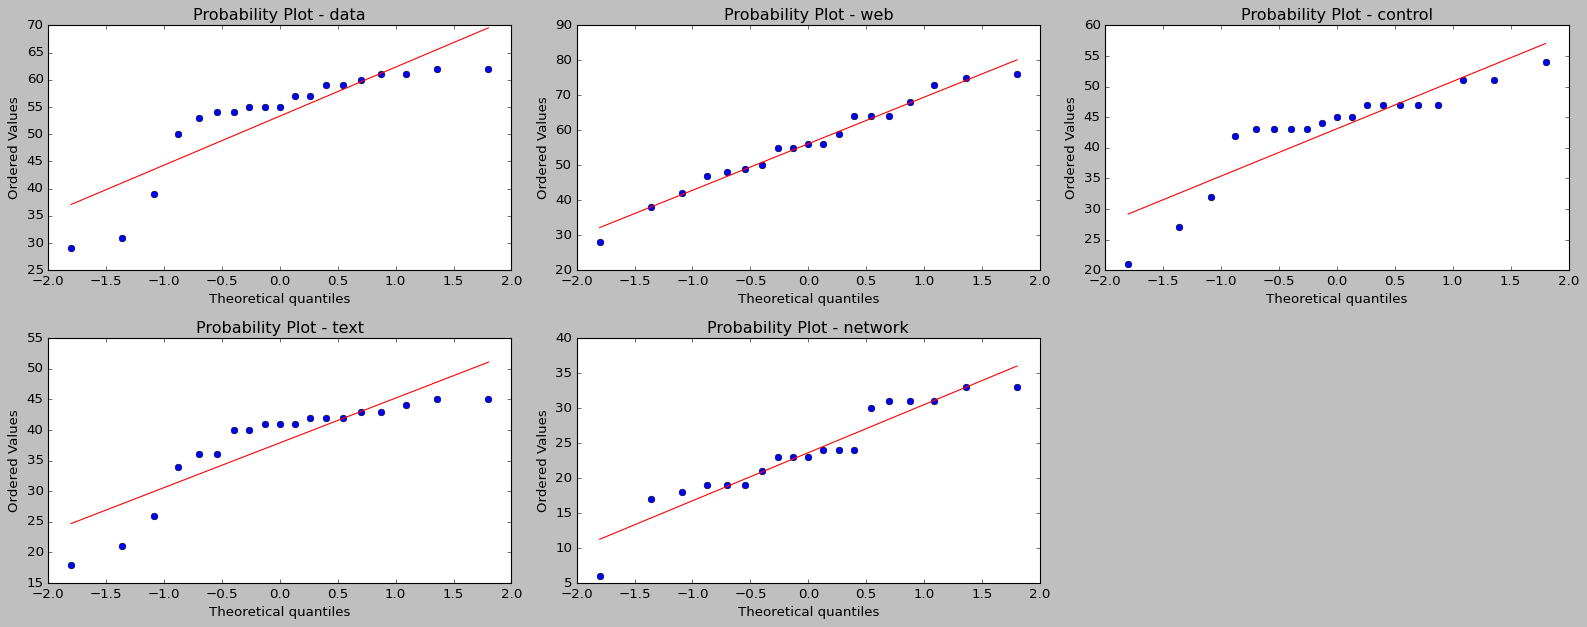

In [14]:
fig = plt.figure(figsize=(20,8))
unique_categories = df_categories['categories'].unique()

for idx,cat in enumerate(unique_categories):
    plt.subplot(2,3,idx+1)
    stats.probplot(df_categories[df_categories['categories'] == cat]['count_pkgs'], dist="norm", plot=plt)
    fig.tight_layout()
    plt.title("Probability Plot - " +  cat)
plt.show()

In [15]:
stats.f_oneway(data,web,control,text,network,others)

F_onewayResult(statistic=275.82456457359814, pvalue=8.705946027387975e-60)

group1,group2,meandiff,p-adj,lower,upper,reject
control,data,10.2105,0.0093,1.7953,18.6257,True
control,network,-19.4737,0.001,-27.8889,-11.0585,True
control,text,-5.2105,0.4265,-13.6257,3.2047,False
control,web,13.0526,0.001,4.6374,21.4678,True
data,network,-29.6842,0.001,-38.0994,-21.269,True
data,text,-15.4211,0.001,-23.8363,-7.0058,True
data,web,2.8421,0.8708,-5.5731,11.2573,False
network,text,14.2632,0.001,5.8479,22.6784,True
network,web,32.5263,0.001,24.1111,40.9415,True
text,web,18.2632,0.001,9.8479,26.6784,True


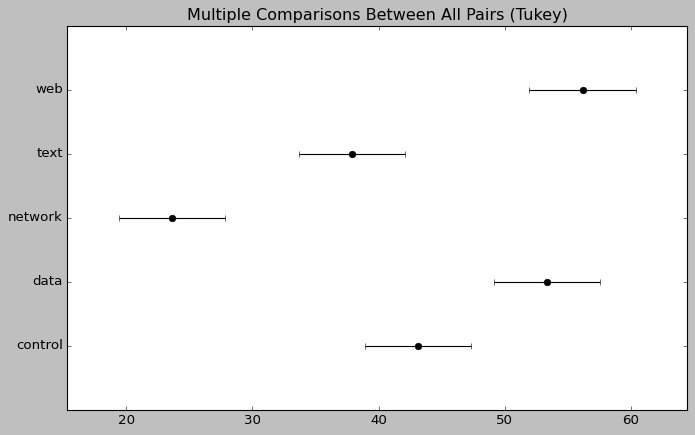

In [16]:
tukey = pairwise_tukeyhsd(endog=df_categories['count_pkgs'],
                         groups=df_categories['categories'],
                         alpha=0.05)
tukey.plot_simultaneous()

tukey.summary()

In [17]:
pvalue_list = []
len_lts = [len(df) for idx,df in enumerate(df_by_category_list)]

for category in count_pkgs_mon.keys():
    if category != 'others':
        list_test_chi = []
        list_lts_len_cat = [count_pkgs[category][idx]-count_pkgs_mon[category][idx] for idx,df in enumerate(df_by_category_list)]

        list_test_chi.append(count_pkgs_mon[category])
        list_test_chi.append(list_lts_len_cat)


        chisq_statistic,pvalue,dof,expected_frep = chi2_contingency(list_test_chi)
        pvalue_list.append(pvalue)
        print(category,' have a pvalue of: ',pvalue)

data  have a pvalue of:  0.046659885388595536
web  have a pvalue of:  0.05446304657956041
control  have a pvalue of:  0.9999796584192104
text  have a pvalue of:  0.9998417462251122
network  have a pvalue of:  0.08235306018352638


## PValue para la estabilidad en Stackage

In [18]:
stabilities = ['', 'experimental', 'stable', 'provisional', 'alpha', 'beta']
data = {
    '': [],
    'experimental': [],
    'stable': [],
    'provisional': [],
    'alpha': [],
    'beta': []
}
count_pkgs = {
    '': [],
    'experimental': [],
    'stable': [],
    'provisional': [],
    'alpha': [],
    'beta': []
}
stability_df = []

df_stability_list = []
for idx, df in enumerate(df_list):
    list_pkg = []
    list_stab = []
    for idx,row in df.iterrows():
        pkg = row['package']
        stabs = row['stability']
        for stab in stabs:
            list_pkg.append(pkg)
            list_stab.append(stab)
    dict_stab = {'package':list_pkg,'stability':list_stab}
    df_stab = pd.DataFrame(dict_stab)
    df_stability_list.append(df_stab)
    
for idx, df in enumerate(df_stability_list):
    aux_df = df[['package', 'stability']]
    aux_df = aux_df.groupby(['stability']).count().reset_index().rename(columns={"package": "count"})
    aux_df.loc[:, 'version'] = lts_list[idx]
    stability_df.append(aux_df.sort_values(by=['count'], ascending=False))

for stability in stabilities:
    for idx, lts in enumerate(df_list):
        total_pkgs = len(df_list[idx])
        
        aux = int(stability_df[idx][stability_df[idx]['stability'] == stability]['count']) * 100 / total_pkgs
        count = int(stability_df[idx][stability_df[idx]['stability'] == stability]['count'])
        count_pkgs[stability].append(count)
        data[stability].append(aux)

stabilities[0]='n/a'
for i in range (len(data['alpha'])):
    data['alpha'][i] = data['alpha'][i]+data['beta'][i]

In [19]:
experimental = count_pkgs['experimental']
stable = count_pkgs['stable']
provisional = count_pkgs['provisional']
alpha = count_pkgs['alpha']
beta = count_pkgs['beta']

In [20]:
count_pkg = experimental + stable + provisional + alpha + beta
stab_list = [stab for idx,stab in enumerate(stabilities[1:]) for jdx,lts in enumerate(lts_list)]
dict_pkg = {'stabilities': stab_list, 'count_pkgs': count_pkg}

df_stabilities = pd.DataFrame(dict_pkg)

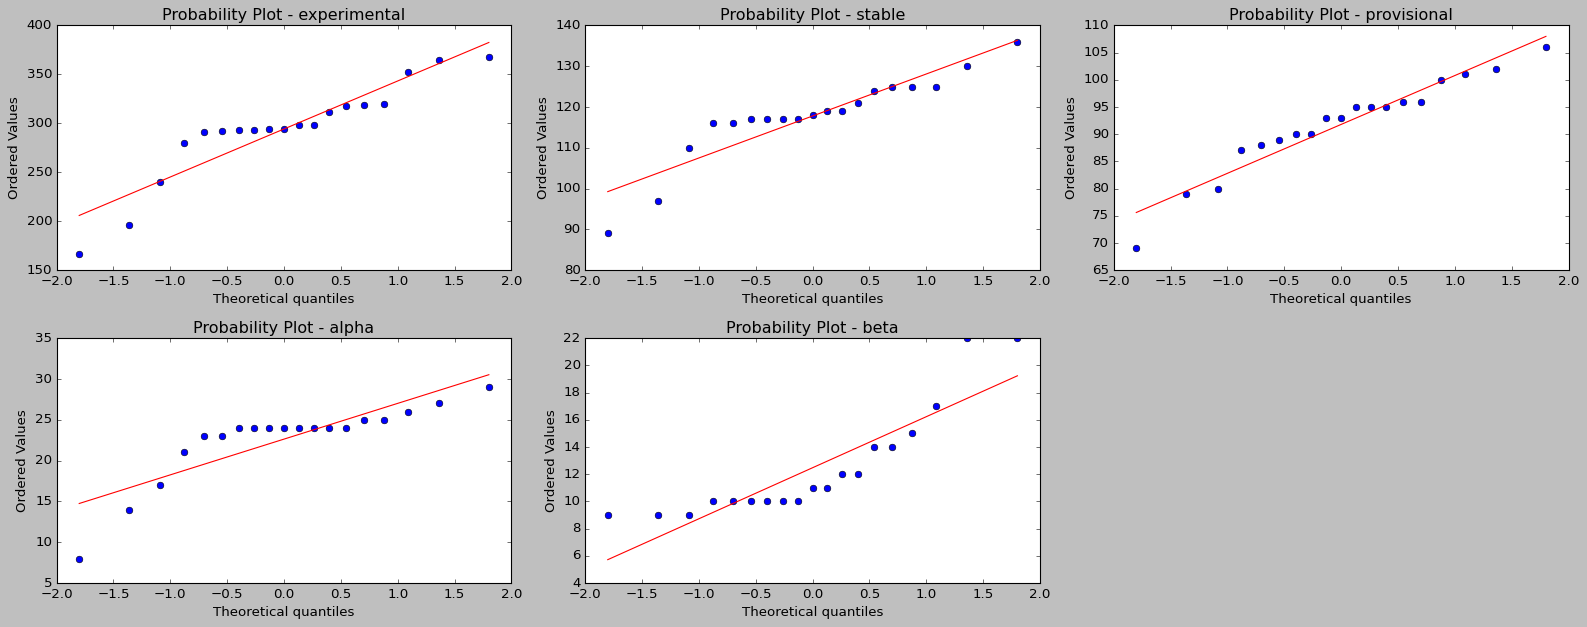

In [21]:
fig = plt.figure(figsize=(20,8))
unique_stabilities = df_stabilities['stabilities'].unique()

for idx,stab in enumerate(unique_stabilities):
    plt.subplot(2,3,idx+1)
    stats.probplot(df_stabilities[df_stabilities['stabilities'] == stab]['count_pkgs'], dist="norm", plot=plt)
    fig.tight_layout()
    plt.title("Probability Plot - " +  stab)
plt.show()

In [22]:
stats.f_oneway(experimental,stable,provisional,alpha,beta)

F_onewayResult(statistic=447.88176053711254, pvalue=1.6978010076026394e-58)

group1,group2,meandiff,p-adj,lower,upper,reject
alpha,beta,-10.1579,0.6464,-31.2552,10.9394,False
alpha,experimental,271.5789,0.001,250.4816,292.6763,True
alpha,provisional,69.1579,0.001,48.0606,90.2552,True
alpha,stable,95.1579,0.001,74.0606,116.2552,True
beta,experimental,281.7368,0.001,260.6395,302.8342,True
beta,provisional,79.3158,0.001,58.2185,100.4131,True
beta,stable,105.3158,0.001,84.2185,126.4131,True
experimental,provisional,-202.4211,0.001,-223.5184,-181.3237,True
experimental,stable,-176.4211,0.001,-197.5184,-155.3237,True
provisional,stable,26.0,0.0079,4.9027,47.0973,True


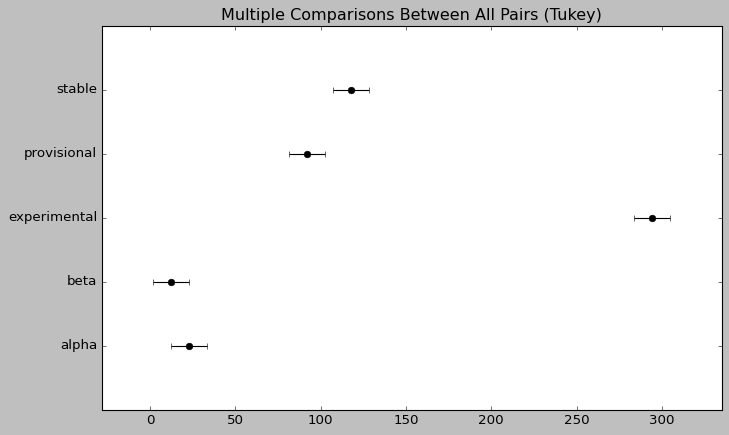

In [23]:
tukey = pairwise_tukeyhsd(endog=df_stabilities['count_pkgs'],
                         groups=df_stabilities['stabilities'],
                         alpha=0.05)
tukey.plot_simultaneous()

tukey.summary()

In [24]:
pvalue_list = []
len_lts = [len(df) for idx,df in enumerate(df_list)]

for stability in count_pkgs.keys():
    list_test_chi = []
    list_lts_len_sta = [len(df)-count_pkgs[stability][idx] for idx,df in enumerate(df_list)]
    
    list_test_chi.append(count_pkgs[stability])
    list_test_chi.append(list_lts_len_sta)
    
    
    chisq_statistic,pvalue,dof,expected_frep = chi2_contingency(list_test_chi)
    pvalue_list.append(pvalue)

    print(stability,' have a pvalue of: ',pvalue) if stability != '' else  print('N/A have a pvalue of: ',pvalue)

N/A have a pvalue of:  1.7229859586094833e-105
experimental  have a pvalue of:  1.0128146416636225e-29
stable  have a pvalue of:  3.3967678011381062e-25
provisional  have a pvalue of:  1.24867815424202e-13
alpha  have a pvalue of:  0.9980487869952832
beta  have a pvalue of:  0.0014462365659655134


## PValue para estabilidad con mónadas

In [25]:
stabilities = ['', 'experimental', 'stable', 'provisional', 'alpha', 'beta']
data = {
    '': [],
    'experimental': [],
    'stable': [],
    'provisional': [],
    'alpha': [],
    'beta': []
}
count_pkgs_mon = {
    '': [],
    'experimental': [],
    'stable': [],
    'provisional': [],
    'alpha': [],
    'beta': []
}
stability_df = []

df_stability_list = []
for idx, df in enumerate(df_list):
    list_pkg = []
    list_stab = []
    list_mtl = []
    for idx,row in df.iterrows():
        pkg = row['package']
        stabs = row['stability']
        mtl = row['mtl-direct']
        for stab in stabs:
            list_pkg.append(pkg)
            list_stab.append(stab)
            list_mtl.append(mtl)
    dict_stab = {'package':list_pkg,'stability':list_stab,'mtl-direct':list_mtl}
    df_stab = pd.DataFrame(dict_stab)
    df_stability_list.append(df_stab)
    
for idx, df in enumerate(df_stability_list):
    aux_df = df[['package', 'stability', 'mtl-direct']]
    aux_df = aux_df[aux_df['mtl-direct'] == 1].groupby(['stability']).count().reset_index().rename(columns={"package": "count"})
    aux_df.loc[:, 'version'] = lts_list[idx]
    stability_df.append(aux_df.sort_values(by=['count'], ascending=False))

for stability in stabilities:
    for idx, lts in enumerate(df_list):
        total_pkgs = len(df_list[idx])
        
        aux = int(stability_df[idx][stability_df[idx]['stability'] == stability]['count']) * 100 / total_pkgs
        count = int(stability_df[idx][stability_df[idx]['stability'] == stability]['count'])
        count_pkgs_mon[stability].append(count)
        data[stability].append(aux)
        
stabilities[0]='n/a'
for i in range (len(data['alpha'])):
    data['alpha'][i] = data['alpha'][i]+data['beta'][i]

In [43]:
suma = 0
for df in df_list:
    suma += len(df)
suma

42790

In [26]:
experimental = count_pkgs_mon['experimental']
stable = count_pkgs_mon['stable']
provisional = count_pkgs_mon['provisional']
alpha = count_pkgs_mon['alpha']
beta = count_pkgs_mon['beta']

In [27]:
count_pkg = experimental + stable + provisional + alpha + beta
stab_list = [stab for idx,stab in enumerate(stabilities[1:]) for jdx,lts in enumerate(lts_list)]
dict_pkg = {'stabilities': stab_list, 'count_pkgs': count_pkg}

df_stabilities = pd.DataFrame(dict_pkg)

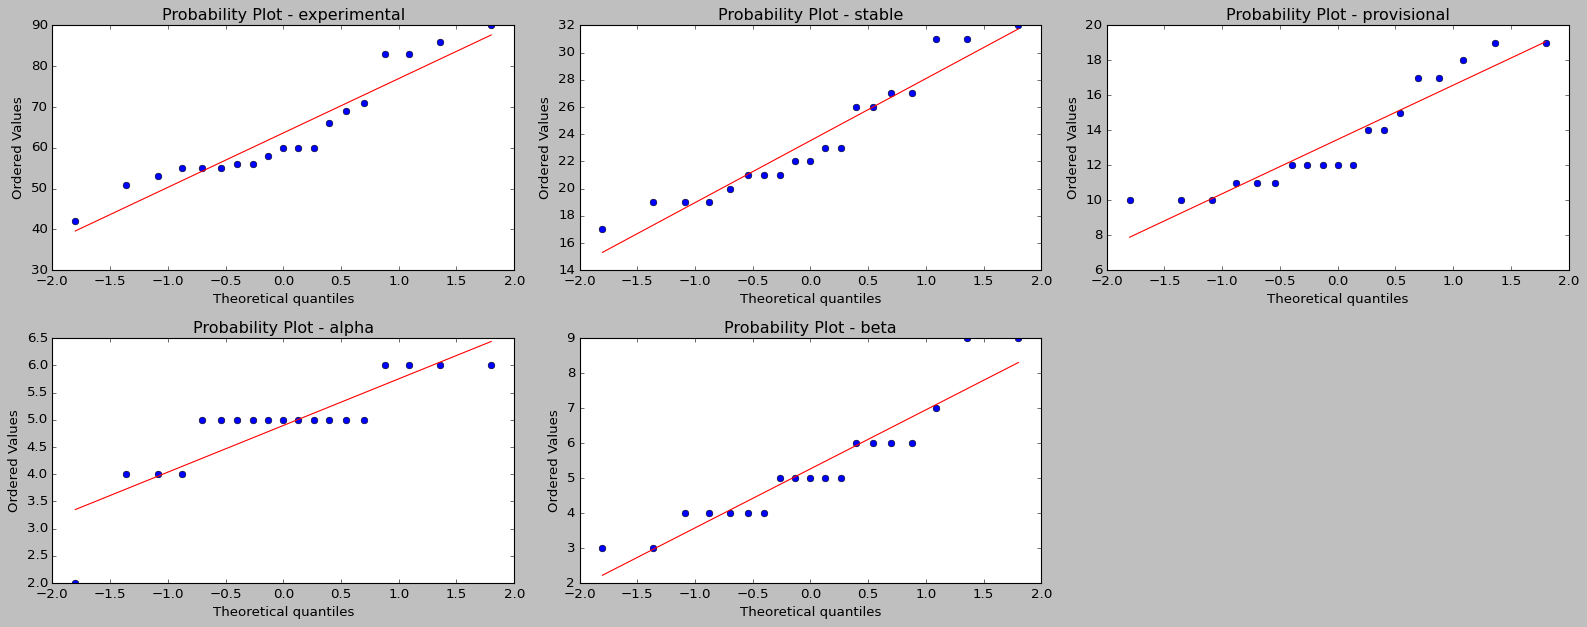

In [28]:
fig = plt.figure(figsize=(20,8))
unique_stabilities = df_stabilities['stabilities'].unique()

for idx,stab in enumerate(unique_stabilities):
    plt.subplot(2,3,idx+1)
    stats.probplot(df_stabilities[df_stabilities['stabilities'] == stab]['count_pkgs'], dist="norm", plot=plt)
    fig.tight_layout()
    plt.title("Probability Plot - " +  stab)
plt.show()

In [29]:
stats.f_oneway(experimental,stable,provisional,alpha,beta)

F_onewayResult(statistic=268.5918358843294, pvalue=3.939789043784701e-49)

group1,group2,meandiff,p-adj,lower,upper,reject
alpha,beta,0.3684,0.9,-5.4923,6.2291,False
alpha,experimental,58.7368,0.001,52.8761,64.5975,True
alpha,provisional,8.5789,0.001,2.7182,14.4397,True
alpha,stable,18.6316,0.001,12.7709,24.4923,True
beta,experimental,58.3684,0.001,52.5077,64.2291,True
beta,provisional,8.2105,0.0017,2.3498,14.0712,True
beta,stable,18.2632,0.001,12.4025,24.1239,True
experimental,provisional,-50.1579,0.001,-56.0186,-44.2972,True
experimental,stable,-40.1053,0.001,-45.966,-34.2446,True
provisional,stable,10.0526,0.001,4.1919,15.9133,True


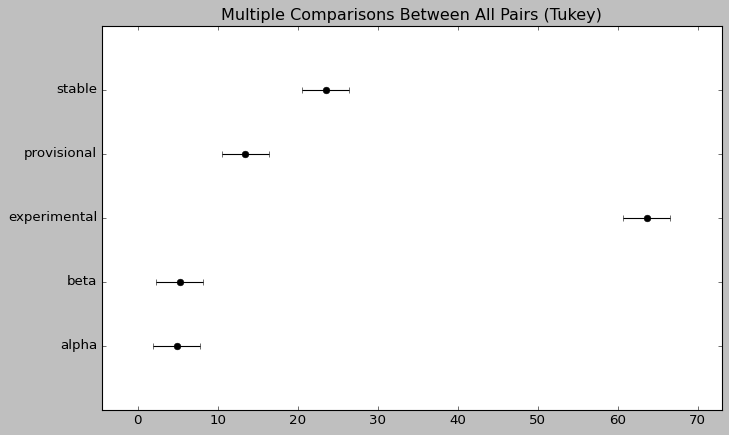

In [30]:
tukey = pairwise_tukeyhsd(endog=df_stabilities['count_pkgs'],
                         groups=df_stabilities['stabilities'],
                         alpha=0.05)
tukey.plot_simultaneous()

tukey.summary()

In [31]:
pvalue_list = []
len_lts = [len(df) for idx,df in enumerate(df_list)]

for stability in count_pkgs_mon.keys():
    list_test_chi = []
    list_lts_len_sta = [count_pkgs[stability][idx]-count_pkgs_mon[stability][idx] for idx,df in enumerate(df_list)]
    
    list_test_chi.append(count_pkgs_mon[stability])
    list_test_chi.append(list_lts_len_sta)
    
    chisq_statistic,pvalue,dof,expected_frep = chi2_contingency(list_test_chi)
    pvalue_list.append(pvalue)

    print(stability,' have a pvalue of: ',pvalue) if stability != '' else  print('N/A have a pvalue of: ',pvalue)

N/A have a pvalue of:  1.4384073672674562e-16
experimental  have a pvalue of:  0.04803413001103403
stable  have a pvalue of:  0.9203013703117717
provisional  have a pvalue of:  0.8712807692248444
alpha  have a pvalue of:  0.9999999953020866
beta  have a pvalue of:  0.9986988289669596


## Calcular PValue para los modulos de mónadas en Stackage

In [32]:
monads_used = [0, 1, 2, 3, 4, 5, 6, 7, 8]
data = create_lts_obj()
monads_used_df = []

for idx, df in enumerate(df_list):
    df = df[df['mtl-direct'] == 1]
    df = compute_monad_usage_by_df(df)
    aux_df = df[['MonadsUsed', 'package']]
    aux_df = aux_df.groupby(['MonadsUsed']).count().reset_index().rename(columns={'package': 'count'})
    monads_used_df.append(aux_df)

c:\users\nicol\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
c:\users\nicol\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\nicol\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 


In [33]:
monads_type = ['State', 'Reader', 'Trans', 'Writer', 'Error', 'Except', 'Identity', 'RWS', 'Continuation', 'List']
monads_type_df_list = []
data = [[], [], [], [], [], [], [], [], [], []]
data_monads = [[], [], [], [], [], [], [], [], [], []]
for idx, df in enumerate(df_list):
    mtl_df = df[df['mtl-direct'] == 1]
    mtl_df = compute_monad_usage_by_df(mtl_df)
    monad_type_series = mtl_df[monads_type].sum().sort_values()
    monad_type_df = pd.DataFrame({ "type": monad_type_series.index, "count": monad_type_series.values })
    monads_type_df_list.append(monad_type_df)
    
for num, monad in enumerate(monads_type):    
    for idx, lts in enumerate(lts_list):
        aux = int(monads_type_df_list[idx][monads_type_df_list[idx]['type'] == monad]['count'])
        data_monads[num].append(aux)
        sum = monads_type_df_list[idx].sum().values[1]
        per = aux * 100 / sum
        data[num].append(per)

for i in range (len(data[1])):
    data[8][i] = data[8][i]+data[9][i]

c:\users\nicol\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
c:\users\nicol\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\nicol\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 


In [34]:
State = data_monads[0]
Reader = data_monads[1]
Trans = data_monads[2]
Writer = data_monads[3]
Error = data_monads[4]
Except = data_monads[5]
Identity = data_monads[6]
RWS = data_monads[7]
Continuation = data_monads[8]
List = data_monads[9]

In [35]:
count_pkg = State + Reader + Trans + Writer + Error + Except + Identity + RWS + Continuation + List 
module_list = [module for idx,module in enumerate(monads_type) for jdx,lts in enumerate(lts_list)]
dict_pkg = {'modules': module_list, 'count_pkgs': count_pkg}

df_modules = pd.DataFrame(dict_pkg)

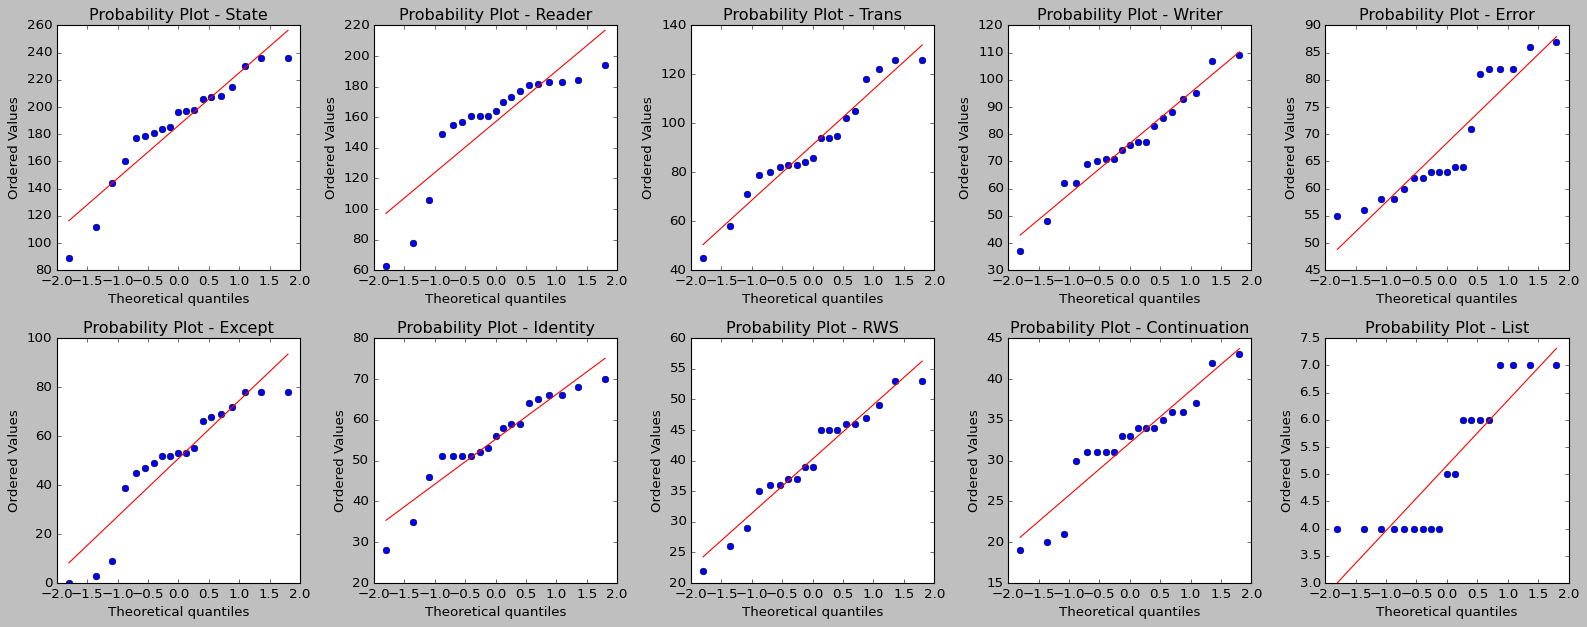

In [36]:
fig = plt.figure(figsize=(20,8))
unique_modules = df_modules['modules'].unique()

for idx,module in enumerate(unique_modules):
    plt.subplot(2,5,idx+1)
    stats.probplot(df_modules[df_modules['modules'] == module]['count_pkgs'], dist="norm", plot=plt)
    fig.tight_layout()
    plt.title("Probability Plot - " +  module)
plt.show()

In [37]:
stats.f_oneway(State,Reader,Trans,Writer,Error,Except,Identity,RWS,Continuation,List)

F_onewayResult(statistic=131.84272035646342, pvalue=2.3267550255216582e-74)

group1,group2,meandiff,p-adj,lower,upper,reject
Continuation,Error,36.2105,0.001,14.0858,58.3353,True
Continuation,Except,18.6842,0.1792,-3.4406,40.809,False
Continuation,Identity,23.0526,0.0337,0.9279,45.1774,True
Continuation,List,-27.0,0.005,-49.1248,-4.8752,True
Continuation,RWS,8.1053,0.9,-14.0195,30.23,False
Continuation,Reader,124.7895,0.001,102.6647,146.9142,True
Continuation,State,154.1579,0.001,132.0331,176.2827,True
Continuation,Trans,59.0526,0.001,36.9279,81.1774,True
Continuation,Writer,44.4211,0.001,22.2963,66.5458,True
Error,Except,-17.5263,0.2558,-39.6511,4.5984,False


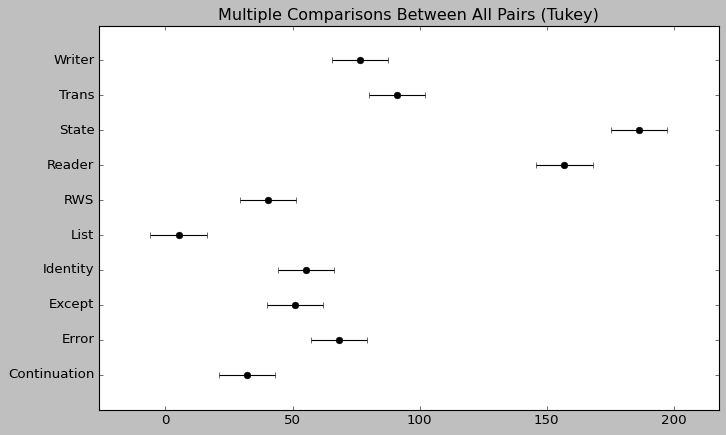

In [38]:
tukey = pairwise_tukeyhsd(endog=df_modules['count_pkgs'],
                         groups=df_modules['modules'],
                         alpha=0.05)
tukey.plot_simultaneous()

tukey.summary()

In [39]:
pvalue_list = []
list_lts_size_mon = []
for idy,lts in enumerate(data_monads[0]):
    size = 0
    for idx,monad_type in enumerate(data_monads):
        size += data_monads[idx][idy]
    list_lts_size_mon.append(size)

for idx,monad_type in enumerate(data_monads):
    list_test_chi = []
    list_lts_len_mon = [list_lts_size_mon[idx]-monad_type[idx] for idx,data in enumerate(list_lts_size_mon)]
    list_test_chi.append(monad_type)
    list_test_chi.append(list_lts_len_mon)
    
    chisq_statistic,pvalue,dof,expected_frep = chi2_contingency(list_test_chi)
    pvalue_list.append(pvalue)
    if idx != 9:
        print(monads_type[idx],' have a pvalue of: ',pvalue) if idx != 8  else print('Continuation and List have a pvalue of: ',pvalue) 

State  have a pvalue of:  0.999999116828304
Reader  have a pvalue of:  0.6608005039214454
Trans  have a pvalue of:  0.4279329940276222
Writer  have a pvalue of:  0.9708566627181792
Error  have a pvalue of:  0.0004946740233493459
Except  have a pvalue of:  4.4339204997822264e-23
Identity  have a pvalue of:  0.9982138270866271
RWS  have a pvalue of:  0.9999941294606133
Continuation and List have a pvalue of:  0.9999582257800097
